In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/TensorQuest')

# **Importing necessary libraries & framework**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional

In [ ]:
df = pd.read_csv('Spam_SMS.csv')
df.head(5)

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])

## Ham is 0
## Spam is 1

In [ ]:
df.head(5)

,Class,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# **Data Processing**

In [ ]:
df.isnull().sum()

,0
Class,0
Message,0


In [ ]:
df.duplicated().sum()

415

In [ ]:
df = df.drop_duplicates(keep='first') ## Cleaning duplicate data

df.duplicated().sum()

0

In [ ]:
df.shape

(5159, 2)

In [ ]:
df['Class'].value_counts()

,count
Class,
0,4518
1,641


# **Feature Engineering**

In [ ]:
nltk.download('punkt')

df['No_of_char'] = df['Message'].apply(len) ## Adding new column of number of characters

df.head(3)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,Class,Message,No_of_char
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155


In [ ]:
nltk.download('punkt_tab')
df['No_of_Word'] = df['Message'].apply(lambda x:len(nltk.word_tokenize(x))) ## Adding new column of number of words

df.head(3)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,Class,Message,No_of_char,No_of_Word
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37


In [ ]:
df['No_of_Sent'] = df['Message'].apply(lambda x:len(nltk.sent_tokenize(x))) ## Number of Sentences

df.sample(10)

,Class,Message,No_of_char,No_of_Word,No_of_Sent
5262,0,If anyone calls for a treadmill say you'll buy...,127,34,3
3658,0,Studying. But i.ll be free next weekend.,40,9,2
1632,0,We not watching movie already. Xy wants 2 shop...,73,18,2
2071,1,Sexy Singles are waiting for you! Text your AG...,149,33,3
3117,0,Uncle Abbey! Happy New Year. Abiola,35,8,3
4637,0,K k pa Had your lunch aha.,26,8,1
367,1,"Update_Now - Xmas Offer! Latest Motorola, Sony...",165,29,4
3232,0,No plm i will come da. On the way.,34,11,2
1951,0,Oh ic. I thought you meant mary jane.,37,10,2
2955,0,Think i might have to give it a miss. Am teach...,112,26,3


In [ ]:
import re

def extract_currency_amounts(text):
    """
    Detects currency symbols and their associated amounts in a text.

    Args:
        text (str): The input text to analyze.

    Returns:
        List[Tuple[str, float]]: A list of tuples containing detected currency symbols and amounts.
    """

    pattern = r'([₹$€£¥])\s?([\d,]+(?:\.\d{1,2})?)'  ## Regular expression to match currency symbols and amounts

    matches = re.findall(pattern, text)  ## Find all matches in the text

    results = [(symbol, float(amount.replace(',', ''))) for symbol, amount in matches] ## Process matches to remove commas from numbers and convert to float

    if not results:
        return 0 ## Returns 0 if no money amount is there
    else:
        return 1 ## Return 1 otherwise



df['isCurrrencyPresent'] = df['Message'].apply(extract_currency_amounts)

df.head(10)

,Class,Message,No_of_char,No_of_Word,No_of_Sent,isCurrrencyPresent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,0
1,0,Ok lar... Joking wif u oni...,29,8,2,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,0
3,0,U dun say so early hor... U c already then say...,49,13,1,0
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0
5,1,FreeMsg Hey there darling it's been 3 week's n...,147,39,4,1
6,0,Even my brother is not like to speak with me. ...,77,18,2,0
7,0,As per your request 'Melle Melle (Oru Minnamin...,160,31,2,0
8,1,WINNER!! As a valued network customer you have...,157,32,5,1
9,1,Had your mobile 11 months or more? U R entitle...,154,31,3,0


In [ ]:
import re

def contains_url(text):
    """
    Checks if a string contains any kind of URL.

    Args:
        text (str): The input string to check.

    Returns:
        int: 1 if the string contains a URL, 0 otherwise.
    """
    url_pattern = re.compile(
        r'(https?://|www\.)'                 # Matches http://, https://, or www.
        r'[\w\-]+(\.[\w\-]+)+'              # Matches domain and subdomains
        r'(:\d+)?'                          # Optional port
        r'(/[^\s]*)?'                       # Optional path
    )
    return 1 if url_pattern.search(text) else 0


df['isURLPresent'] = df['Message'].apply(extract_currency_amounts)

df.head(10)

,Class,Message,No_of_char,No_of_Word,No_of_Sent,isCurrrencyPresent,isURLPresent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,0,0
1,0,Ok lar... Joking wif u oni...,29,8,2,0,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,0,0
3,0,U dun say so early hor... U c already then say...,49,13,1,0,0
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0,0
5,1,FreeMsg Hey there darling it's been 3 week's n...,147,39,4,1,1
6,0,Even my brother is not like to speak with me. ...,77,18,2,0,0
7,0,As per your request 'Melle Melle (Oru Minnamin...,160,31,2,0,0
8,1,WINNER!! As a valued network customer you have...,157,32,5,1,1
9,1,Had your mobile 11 months or more? U R entitle...,154,31,3,0,0


# **Analysing data**

In [ ]:
print(df[df['Class'] == 0]['isCurrrencyPresent'].sum()) ## Number of HAM messages which contains money amount

print(df[df['Class'] == 1]['isCurrrencyPresent'].sum()) ## Number of SPAM messages which contains money amount

12
212


In [ ]:
df[df['Class'] == 0][['No_of_char','No_of_Word','No_of_Sent']].describe() ## Statistical analysis of Ham

,No_of_char,No_of_Word,No_of_Sent
count,4518.000000,4518.000000,4518.000000
mean,70.861000,17.302125,1.827579
std,56.584513,13.592056,1.394245
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,91.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [ ]:
df[df['Class'] == 1][['No_of_char','No_of_Word','No_of_Sent']].describe() ## Statistical analysis of Spam

,No_of_char,No_of_Word,No_of_Sent
count,641.000000,641.000000,641.000000
mean,137.413417,27.722309,2.979719
std,29.998996,7.032577,1.483627
min,13.000000,2.000000,1.000000
25%,131.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


<Axes: xlabel='No_of_char', ylabel='Count'>

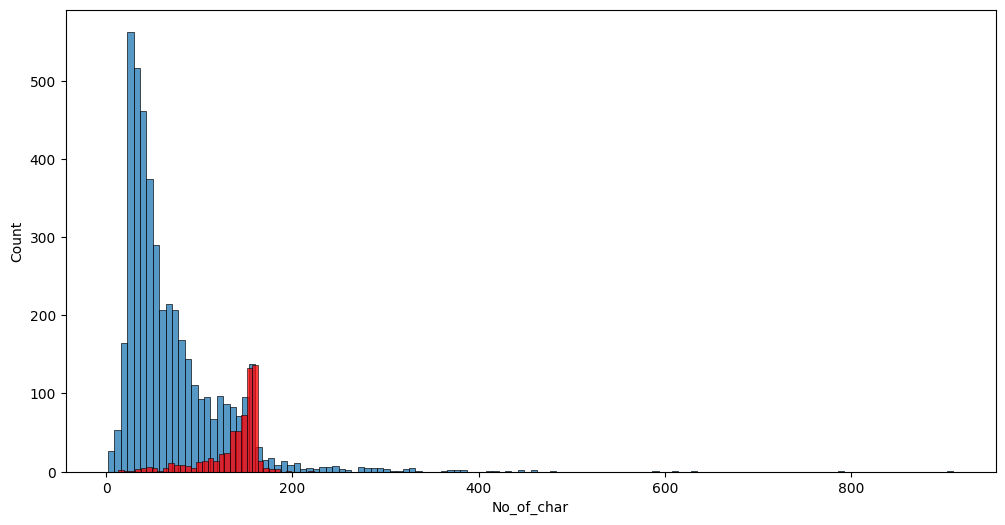

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['Class'] == 0]['No_of_char'])
sns.histplot(df[df['Class'] == 1]['No_of_char'] ,color='red')

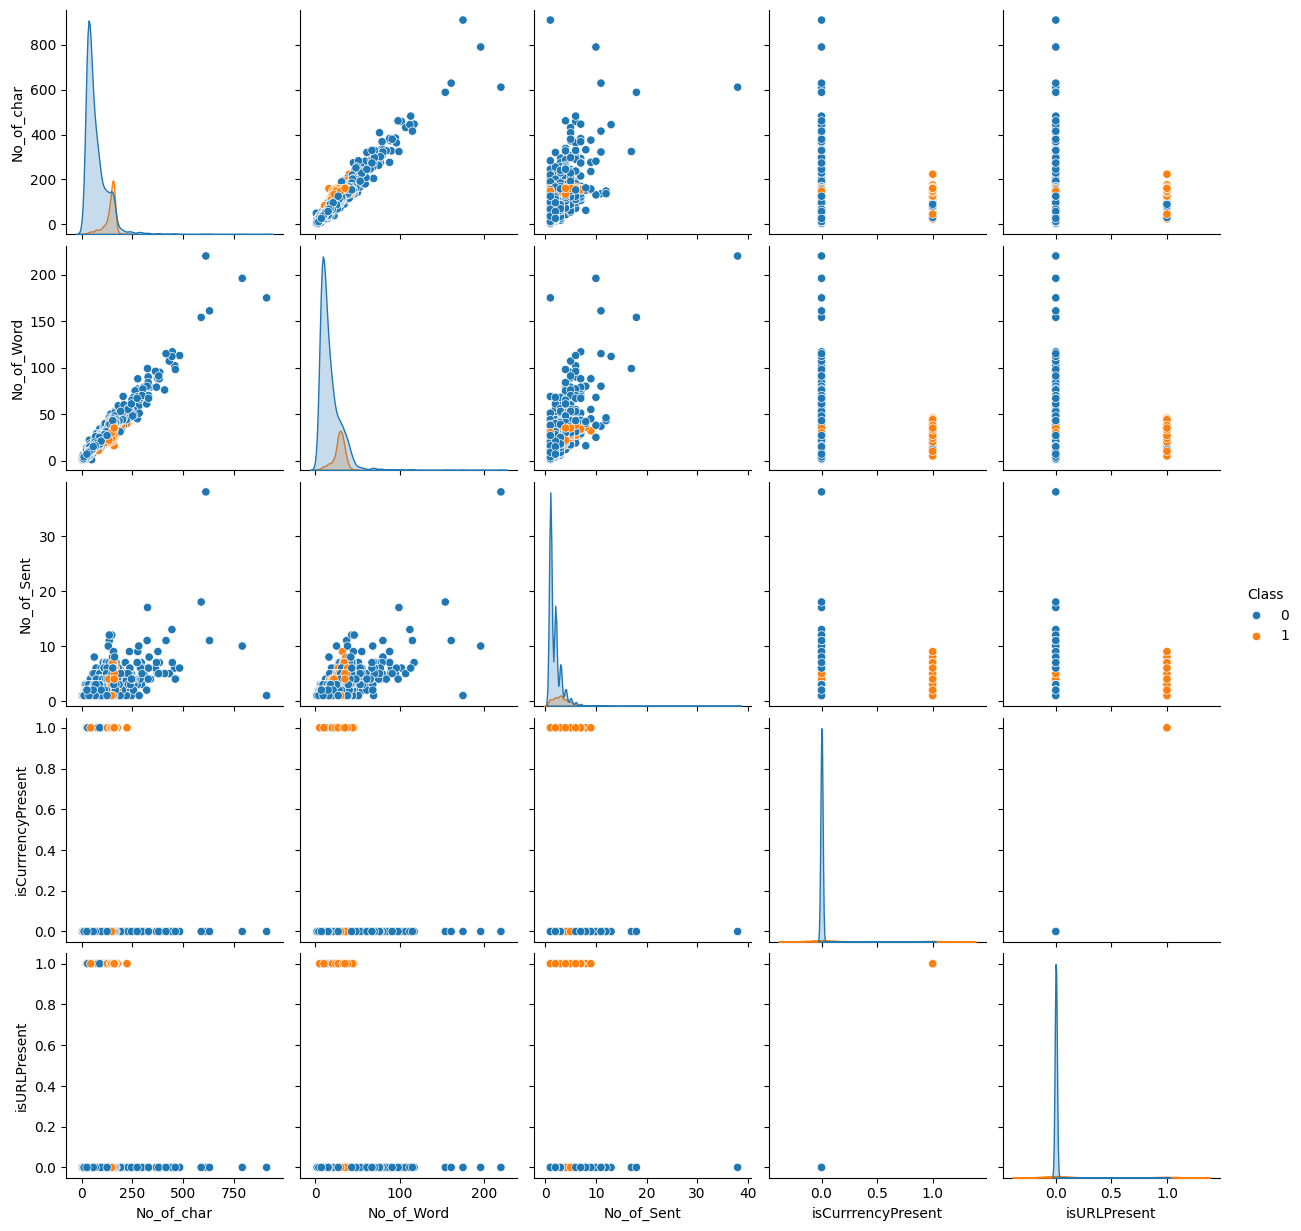

In [ ]:
sns.pairplot(df, hue = 'Class')

# **Applying LSTM over raw text data**

In [ ]:
X = df['Message']
y = df['Class']
X.shape

(5159,)

In [ ]:
# Features = df.drop('Class',axis=1)
# Features = Features.drop('Message',axis=1)
# Features.shape

(5159, 5)

In [ ]:
# Features.head(1)

,No_of_char,No_of_Word,No_of_Sent,isCurrrencyPresent,isURLPresent
0,111,24,2,0,0


In [ ]:
# Text tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=100)

In [ ]:
def create_Blstm_model(i_dim, i_length):
    from tensorflow.keras.layers import Bidirectional

    model = Sequential([
        Embedding(input_dim=i_dim, output_dim=128, input_length=i_length),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dense(64, activation='relu', kernel_regularizer='l2'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold Cross Validation

accuracy_scores_LSTM = []
precision_scores_LSTM = []
recall_scores_LSTM = []
f1_scores_LSTM = []

for train_index, val_index in kf.split(padded_sequences):
    X_train, X_val = padded_sequences[train_index], padded_sequences[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = create_Blstm_model(10000, 100)

    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

    y_val_pred = (model.predict(X_val) > 0.5).astype(int)

    accuracy_scores_LSTM.append(accuracy_score(y_val, y_val_pred))
    precision_scores_LSTM.append(precision_score(y_val, y_val_pred))
    recall_scores_LSTM.append(recall_score(y_val, y_val_pred))
    f1_scores_LSTM.append(f1_score(y_val, y_val_pred))


print("LSTM Accuracy : ", np.mean(accuracy_scores_LSTM))
print("LSTM Precision : ", np.mean(precision_scores_LSTM))
print("LSTM Recall : ", np.mean(recall_scores_LSTM))
print("LSTM F1 Score : ", np.mean(f1_scores_LSTM))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8966 - loss: 0.8434 - val_accuracy: 0.9826 - val_loss: 0.2125
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9941 - loss: 0.1423 - val_accuracy: 0.9845 - val_loss: 0.0928
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9987 - loss: 0.0431 - val_accuracy: 0.9816 - val_loss: 0.0774
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9991 - loss: 0.0225 - val_accuracy: 0.9806 - val_loss: 0.0795
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9991 - loss: 0.0148 - val_accuracy: 0.9835 - val_loss: 0.0820
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9071 - loss: 0.8446 - val_accuracy: 0.9864 - val_loss: 0.1987
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9889 - loss: 0.1408 - val_accuracy: 0.9835 - val_loss: 0.0877
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9967 - loss: 0.0402 - val_accuracy: 0.9903 - val_loss: 0.0513
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9989 - loss: 0.0246 - val_accuracy: 0.9893 - val_loss: 0.0510
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9990 - loss: 0.0188 - val_accuracy: 0.9922 - val_loss: 0.0442
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8792 - loss: 0.8400 - val_accuracy: 0.9787 - val_loss: 0.2037
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9903 - loss: 0.1306 - val_accuracy: 0.9893 - val_loss: 0.0686
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9984 - loss: 0.0376 - val_accuracy: 0.9787 - val_loss: 0.0811
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9952 - loss: 0.0304 - val_accuracy: 0.9826 - val_loss: 0.0726
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9979 - loss: 0.0199 - val_accuracy: 0.9845 - val_loss: 0.0621
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8890 - loss: 0.8355 - val_accuracy: 0.9942 - val_loss: 0.1624
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9927 - loss: 0.1156 - val_accuracy: 0.9864 - val_loss: 0.0770
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9996 - loss: 0.0302 - val_accuracy: 0.9874 - val_loss: 0.0507
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9972 - loss: 0.0230 - val_accuracy: 0.9903 - val_loss: 0.0520
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9993 - loss: 0.0116 - val_accuracy: 0.9835 - val_loss: 0.0623
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8914 - loss: 0.8460 - val_accuracy: 0.9767 - val_loss: 0.2156
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9939 - loss: 0.1227 - val_accuracy: 0.9806 - val_loss: 0.0976
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9971 - loss: 0.0384 - val_accuracy: 0.9796 - val_loss: 0.0914
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9999 - loss: 0.0147 - val_accuracy: 0.9758 - val_loss: 0.1075
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9993 - loss: 0.0114 - val_accuracy: 0.9709 - val_loss: 0.1414
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
LSTM Accuracy :  0.9829400972939647
LSTM Precision :  0.9559228268004072
LSTM Recall :  0.9064849110195133
LSTM F1 Score :  0.9287817357220473


In [ ]:
import pickle

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Save the model
model.save('spam_classifier_Blstm.h5')

# **Now, applying NLP technique**

In [ ]:
df.head(1)

,Class,Message,No_of_char,No_of_Word,No_of_Sent,isCurrrencyPresent,isURLPresent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,0,0


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

import string
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def transform_text(text):
  text = text.lower()
  text = nltk.word_tokenize(text)

  y = []
  for i in text:
    if i.isalnum():
      y.append(i)

  text = y[:]
  y.clear()

  for i in text:
    if i not in stopwords.words('english') and i not in string.punctuation:
      y.append(i)

  text = y[:]
  y.clear()

  for i in text:
    y.append(ps.stem(i))

  return " ".join(y)

In [ ]:
transform_text("I love you darling.")

'love darl'

In [ ]:
df['Transformed_Message'] = df['Message'].apply(transform_text)

In [ ]:
df.head(10)

,Class,Message,No_of_char,No_of_Word,No_of_Sent,isCurrrencyPresent,isURLPresent,Transformed_Message
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,0,0,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,0,0,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,0,0,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,0,0,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0,0,nah think goe usf live around though
5,1,FreeMsg Hey there darling it's been 3 week's n...,147,39,4,1,1,freemsg hey darl 3 week word back like fun sti...
6,0,Even my brother is not like to speak with me. ...,77,18,2,0,0,even brother like speak treat like aid patent
7,0,As per your request 'Melle Melle (Oru Minnamin...,160,31,2,0,0,per request mell oru minnaminungint nurungu ve...
8,1,WINNER!! As a valued network customer you have...,157,32,5,1,1,winner valu network custom select receivea pri...
9,1,Had your mobile 11 months or more? U R entitle...,154,31,3,0,0,mobil 11 month u r entitl updat latest colour ...


In [ ]:
spam_words = []

for msg in df[df['Class'] == 1]['Transformed_Message'].tolist():
  for words in msg.split():
      spam_words.append(words)  ## Collecting spam words

len(spam_words)

9792

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000)

X = tfidf.fit_transform(df['Transformed_Message']).toarray()
y = df['Class'].values
X.shape

(5159, 3000)

In [ ]:
from sklearn.model_selection import train_test_split, KFold
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=16)
kf = KFold(n_splits=5, shuffle=True, random_state=16)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

In [ ]:
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB-G': gnb,
    'NB-M': mnb,
    'NB-B': bnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT': gbdt,
    'xgb': xgb
}

In [ ]:
def train_classifier(clf, X_train, y_train, X_val, y_val):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    return accuracy, precision, recall, f1

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for name, clf in clfs.items():
    current_accuracy = []
    current_precision = []
    current_recall = []
    current_f1 = []
    for train_index, val_index in kf.split(X):
        F_train, F_val = X[train_index], X[val_index]
        y_train, y_test = y[train_index], y[val_index]
        accuracy, precision, recall, f1 = train_classifier(clf, F_train, y_train, F_val, y_test)
        current_accuracy.append(accuracy)
        current_precision.append(precision)
        current_recall.append(recall)
        current_f1.append(f1)
        print("For ", name)
    print("Mean accuracy: ", np.mean(current_accuracy))
    print("Mean precision: ", np.mean(current_precision))
    print("Mean recall: ", np.mean(current_recall))
    print("Mean f1 score: ", np.mean(current_f1))
    print()
    accuracy_scores.append(np.mean(current_accuracy))
    precision_scores.append(np.mean(current_precision))
    recall_scores.append(np.mean(current_recall))
    f1_scores.append(np.mean(current_f1))
    print()


For  SVC
For  SVC
For  SVC
For  SVC
For  SVC
Mean accuracy:  0.9736385235979217
Mean precision:  0.9592373719442723
Mean recall:  0.8218535995554399
Mean f1 score:  0.8850163124428765


For  KN
For  KN
For  KN
For  KN
For  KN
Mean accuracy:  0.9135491620237746
Mean precision:  0.9952380952380953
Mean recall:  0.3057447624162849
Mean f1 score:  0.4673545529960349


For  NB-G
For  NB-G
For  NB-G
For  NB-G
For  NB-G
Mean accuracy:  0.8658649689095406
Mean precision:  0.47779300561463744
Mean recall:  0.8513579704170248
Mean f1 score:  0.6116778011830399


For  NB-M
For  NB-M
For  NB-M
For  NB-M
For  NB-M
Mean accuracy:  0.9730561883923938
Mean precision:  0.9958762886597938
Mean recall:  0.7867671339417462
Mean f1 score:  0.8787079373253874


For  NB-B
For  NB-B
For  NB-B
For  NB-B
For  NB-B
Mean accuracy:  0.9810034285972075
Mean precision:  0.9803566465669122
Mean recall:  0.8631566440079317
Mean f1 score:  0.9178761070706599


For  DT
For  DT
For  DT
For  DT
For  DT
Mean accuracy:  0.9

In [ ]:
performance_df = pd.DataFrame({
    'Classifier': clfs.keys(),
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
}).sort_values('Precision', ascending=False)

In [ ]:
performance_df

,Classifier,Accuracy,Precision,Recall,F1 Score
3,NB-M,0.973056,0.995876,0.786767,0.878708
1,KN,0.913549,0.995238,0.305745,0.467355
4,NB-B,0.981003,0.980357,0.863157,0.917876
7,RF,0.972475,0.980333,0.794081,0.876972
10,ETC,0.976739,0.970052,0.837503,0.898721
0,SVC,0.973639,0.959237,0.821854,0.885016
11,GBDT,0.951541,0.952515,0.640464,0.765707
12,xgb,0.969180,0.944715,0.798220,0.864693
6,LR,0.955805,0.928974,0.697576,0.795955
9,BgC,0.960652,0.865836,0.807660,0.834344


In [ ]:
import pickle

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_test = y[train_index], y[val_index]
    accuracy, precision, recall, f1 = train_classifier(bnb, X_train, y_train, X_val, y_test)

# Save the trained model to a file
filename = 'bernoulli_naive_bayes_model.sav'
pickle.dump(bnb, open(filename, 'wb'))

# **Training Extra Tree Classifier with extra features(BAD)**

In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier
# etc = ExtraTreesClassifier(n_estimators=100, random_state=42, bootstrap=True)

# etc_acc_score = []
# etc_prc_score = []
# etc_rec_score = []
# etc_f_score = []

# for train_index, test_index in kf.split(X):
#     # Split the data
#     F_train, F_test = Features.iloc[train_index], Features.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     etc.fit(F_train, y_train)
#     y_pred = etc.predict(F_test)
#     etc_acc_score.append(accuracy_score(y_test, y_pred))
#     etc_prc_score.append(precision_score(y_test, y_pred))
#     etc_rec_score.append(recall_score(y_test, y_pred))
#     etc_f_score.append(f1_score(y_test, y_pred))

# print("ExtraTreesClassifier Accuracy:", np.mean(etc_acc_score))
# print("ExtraTreesClassifier Precision:", np.mean(etc_prc_score))
# print("ExtraTreesClassifier Recall:", np.mean(etc_rec_score))
# print("ExtraTreesClassifier F1 Score:", np.mean(etc_f_score))

ExtraTreesClassifier Accuracy: 0.9352568440364213
ExtraTreesClassifier Precision: 0.7769534108705007
ExtraTreesClassifier Recall: 0.6721977044415374
ExtraTreesClassifier F1 Score: 0.7197237701961201


# **Combining Model(Didn't work well)**

In [ ]:
# # Get LSTM embeddings
# lstm_embeddings = model.predict(padded_sequences)

# # Combine LSTM embeddings with AdaBoost features
# combined_features = np.concatenate((lstm_embeddings, Features), axis=1)

# # Initialize and train AdaBoost classifier with combined features
# abc = AdaBoostClassifier(n_estimators=50, random_state=42)

# # Example using KFold (replace with your actual KFold setup if different)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# accuracy_scores_combined = []
# precision_scores_combined = []
# recall_scores_combined = []
# f1_scores_combined = []

# for train_index, val_index in kf.split(combined_features):
#     X_train_combined, X_val_combined = combined_features[train_index], combined_features[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     abc.fit(X_train_combined, y_train)
#     y_pred_combined = abc.predict(X_val_combined)

#     accuracy_scores_combined.append(accuracy_score(y_val, y_pred_combined))
#     precision_scores_combined.append(precision_score(y_val, y_pred_combined))
#     recall_scores_combined.append(recall_score(y_val, y_pred_combined))
#     f1_scores_combined.append(f1_score(y_val, y_pred_combined))

# print("AdaBoost with combined features Accuracy:", np.mean(accuracy_scores_combined))
# print("AdaBoost with combined features Precision:", np.mean(precision_scores_combined))
# print("AdaBoost with combined features Recall:", np.mean(recall_scores_combined))
# print("AdaBoost with combined features F1 Score:", np.mean(f1_scores_combined))

162/162 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step
AdaBoost with combined features Accuracy: 0.9945687561560612
AdaBoost with combined features Precision: 0.9836134453781513
AdaBoost with combined features Recall: 0.9757841164634868
AdaBoost with combined features F1 Score: 0.9796142917598694


In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('spam_classifier_Blstm.h5')

In [ ]:
# import pickle

# # Load the tokenizer
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [ ]:
# import joblib

# abc_combined_model = joblib.load('abc_combined_model.pkl')


In [ ]:
# import numpy as np
# import pickle
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import joblib
# import nltk
# import re

# # Load the saved LSTM model
# lstm_model = load_model('spam_classifier_Blstm.h5')

# # Load the AdaBoost combined model
# abc_model = joblib.load('abc_combined_model.pkl')

# # Load the tokenizer
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

# # Download necessary NLTK resources
# nltk.download('punkt')

# # Define helper functions for feature extraction
# def extract_currency_amounts(text):
#     pattern = r'([₹$€£¥])\s?([\d,]+(?:\.\d{1,2})?)'
#     matches = re.findall(pattern, text)
#     results = [(symbol, float(amount.replace(',', ''))) for symbol, amount in matches]
#     return 1 if results else 0

# def contains_url(text):
#     url_pattern = re.compile(r'(https?://|www\.)[\w\-]+(\.[\w\-]+)+(:\d+)?(/[^\s]*)?')
#     return 1 if url_pattern.search(text) else 0

# def extract_features(message):
#     """
#     Extracts numerical features from a single SMS message.

#     Args:
#         message (str): The input SMS message.

#     Returns:
#         np.ndarray: A numpy array of features.
#     """
#     no_of_char = len(message)
#     no_of_word = len(nltk.word_tokenize(message))
#     no_of_sent = len(nltk.sent_tokenize(message))
#     is_currency_present = extract_currency_amounts(message)
#     is_url_present = contains_url(message)

#     return np.array([no_of_char, no_of_word, no_of_sent, is_currency_present, is_url_present])

# # Define a function to preprocess the SMS message
# def preprocess_message(message):
#     """
#     Preprocesses an SMS message to make it suitable for prediction.

#     Args:
#         message (str): The SMS message to preprocess.

#     Returns:
#         np.ndarray: Preprocessed padded sequence and numerical features.
#     """
#     # Tokenize the message
#     sequence = tokenizer.texts_to_sequences([message])
#     # Pad the sequence
#     padded_sequence = pad_sequences(sequence, maxlen=100)
#     # Extract numerical features
#     numerical_features = extract_features(message)

#     return padded_sequence, numerical_features

# # Define a function to predict spam/ham
# def predict_sms(message):
#     """
#     Predicts whether an SMS is spam or ham using LSTM and AdaBoost.

#     Args:
#         message (str): The SMS message to predict.

#     Returns:
#         str: "Spam" or "Ham".
#     """
#     # Preprocess the message
#     padded_sequence, numerical_features = preprocess_message(message)

#     # Get LSTM embeddings
#     lstm_embedding = lstm_model.predict(padded_sequence)

#     # Combine LSTM embedding with numerical features
#     combined_features = np.concatenate((lstm_embedding, numerical_features.reshape(1, -1)), axis=1)

#     # Predict using AdaBoost
#     prediction = abc_model.predict(combined_features)

#     return "Spam" if prediction[0] == 1 else "Ham"

# # Test the function
# message = "Congratulations! You have won a $1000 Walmart gift card. Click here to claim: http://bit.ly/win1000"
# result = predict_sms(message)
# print(f"The message is classified as: {result}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The message is classified as: Ham


In [ ]:
# import numpy as np
# import pandas as pd
# import pickle
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import xgboost as xgb
# import nltk
# import re

# # Load necessary models and tokenizer
# lstm_model = load_model('spam_classifier_Blstm.h5')

# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

# # Download necessary NLTK resources
# nltk.download('punkt')

# # Helper functions for feature extraction
# def extract_currency_amounts(text):
#     pattern = r'([₹$€£¥])\s?([\d,]+(?:\.\d{1,2})?)'
#     matches = re.findall(pattern, text)
#     return 1 if matches else 0

# def contains_url(text):
#     url_pattern = re.compile(r'(https?://|www\.)[\w\-]+(\.[\w\-]+)+(:\d+)?(/[^\s]*)?')
#     return 1 if url_pattern.search(text) else 0

# def extract_features(message):
#     no_of_char = len(message)
#     no_of_word = len(nltk.word_tokenize(message))
#     no_of_sent = len(nltk.sent_tokenize(message))
#     is_currency_present = extract_currency_amounts(message)
#     is_url_present = contains_url(message)

#     return np.array([no_of_char, no_of_word, no_of_sent, is_currency_present, is_url_present])

# # Preprocess message
# def preprocess_message(message):
#     sequence = tokenizer.texts_to_sequences([message])
#     padded_sequence = pad_sequences(sequence, maxlen=100)
#     numerical_features = extract_features(message)
#     return padded_sequence, numerical_features

# # Train Gradient Boosting on numerical features
# def train_gradient_boosting(X_train, y_train):
#     gb_model = xgb.XGBClassifier(n_estimators=50, random_state=42, use_label_encoder=False, eval_metric='logloss')
#     gb_model.fit(X_train, y_train)
#     return gb_model

# # Train and evaluate the combined model
# def train_combined_model(X_sequences, X_features, y):
#     from sklearn.model_selection import train_test_split
#     from sklearn.ensemble import StackingClassifier

#     # Split data
#     X_train_seq, X_test_seq, X_train_feat, X_test_feat, y_train, y_test = train_test_split(
#         X_sequences, X_features, y, test_size=0.2, random_state=42
#     )

#     # Train LSTM model on sequences
#     lstm_embeddings_train = lstm_model.predict(X_train_seq)
#     lstm_embeddings_test = lstm_model.predict(X_test_seq)

#     # Train Gradient Boosting model on features
#     gb_model = train_gradient_boosting(X_train_feat, y_train)

#     # Get Gradient Boosting probabilities
#     gb_train_probs = gb_model.predict_proba(X_train_feat)[:, 1].reshape(-1, 1)
#     gb_test_probs = gb_model.predict_proba(X_test_feat)[:, 1].reshape(-1, 1)

#     # Combine LSTM and Gradient Boosting outputs
#     combined_train = np.hstack((lstm_embeddings_train, gb_train_probs))
#     combined_test = np.hstack((lstm_embeddings_test, gb_test_probs))

#     # Train a meta-classifier on the combined data
#     meta_clf = LogisticRegression()
#     meta_clf.fit(combined_train, y_train)

#     # Evaluate the model
#     y_pred = meta_clf.predict(combined_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)

#     print("Combined Model Performance:")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}")

#     return meta_clf, gb_model

# # Load your data and train the combined model
# df = pd.read_csv('Spam_SMS.csv')
# df['Class'] = df['Class'].map({'ham': 0, 'spam': 1})
# X_sequences = pad_sequences(tokenizer.texts_to_sequences(df['Message']), maxlen=100)
# X_features = np.array([extract_features(msg) for msg in df['Message']])
# y = df['Class']

# # Train the model
# meta_model, gb_model = train_combined_model(X_sequences, X_features, y)

# # Save the meta-classifier and Gradient Boosting model
# import joblib
# joblib.dump(meta_model, 'meta_model.pkl')
# joblib.dump(gb_model, 'gradient_boosting_model.pkl')

# # Prediction Function
# def predict_sms(message):
#     padded_sequence, numerical_features = preprocess_message(message)

#     # Get LSTM embedding and Gradient Boosting probability
#     lstm_embedding = lstm_model.predict(padded_sequence)
#     gb_prob = gb_model.predict_proba(numerical_features.reshape(1, -1))[:, 1]

#     # Combine and predict
#     combined_features = np.hstack((lstm_embedding, gb_prob.reshape(1, -1)))
#     prediction = meta_model.predict(combined_features)

#     return "Spam" if prediction[0] == 1 else "Ham"

# # Test the function
# test_message = "Win a $500 Amazon gift card now! Click here: http://winbig.com"
# result = predict_sms(test_message)
# print(f"The message is classified as: {result}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 209ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step
Combined Model Performance:
Accuracy: 0.9426
Precision: 0.8489
Recall: 0.7329
F1 Score: 0.7867


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:37:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
The message is classified as: Ham


# **Using DNN**

In [ ]:
from tensorflow.keras.models import load_model

lstm_model = load_model('spam_classifier_Blstm.h5')

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
classical_ml = pickle.load(open('bernoulli_naive_bayes_model.sav', 'rb'))

In [ ]:
def create_fcnn():
    model = Sequential([
        Dense(64, input_dim=2, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# def train_extra_trees(X_train, y_train):
#     etc_model = ExtraTreesClassifier(n_estimators=50, random_state=42)
#     etc_model.fit(X_train, y_train)
#     return etc_model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lstm_embeddings_train = lstm_model.predict(X_train)
lstm_embeddings_test = lstm_model.predict(X_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 749s 6s/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step


In [ ]:
# Get the training probabilities of classical ml model
train_probs = classical_ml.predict_proba(X_train)[:, 1]
test_probs = classical_ml.predict_proba(X_test)[:, 1]

train_probs = train_probs.reshape(-1, 1)
test_probs = test_probs.reshape(-1, 1)

train_combined = np.hstack((lstm_embeddings_train, train_probs))
test_combined = np.hstack((lstm_embeddings_test, test_probs))

In [ ]:
fcnn = create_fcnn()
fcnn.fit(train_combined, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9534 - loss: 0.5828 - val_accuracy: 0.9782 - val_loss: 0.1483
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0993 - val_accuracy: 0.9782 - val_loss: 0.0843
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9875 - loss: 0.0618 - val_accuracy: 0.9806 - val_loss: 0.0818
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0602 - val_accuracy: 0.9806 - val_loss: 0.0816
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9838 - loss: 0.0776 - val_accuracy: 0.9831 - val_loss: 0.0812
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0652 - val_accuracy: 0.9831 - val_loss: 0.0825
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0647 - val_accuracy: 0.9831 - val_loss: 0.0827
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.0715 - val_accuracy: 0.9855 - val_

In [ ]:
# Evaluate FCNN
y_pred_prob = fcnn.predict(test_combined)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("FCNN Combined Model Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
FCNN Combined Model Performance:
Accuracy: 0.9893410852713178
Precision: 0.9824561403508771
Recall: 0.9256198347107438
F1 Score: 0.9531914893617022


In [ ]:
# Save the FCNN
fcnn.save('fcnn_combined_model_etc.h5')

# **Testing Zone**

In [ ]:
# prompt: Store the tfidf vectorizer

import pickle
# Assuming 'tfidf' is the TfidfVectorizer object you want to save
filename = 'tfidf_vectorizer.pkl'
pickle.dump(tfidf, open(filename, 'wb'))


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the models
lstm_model = load_model('spam_classifier_Blstm.h5')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
classical_ml = pickle.load(open('bernoulli_naive_bayes_model.sav', 'rb'))
fcnn = load_model('fcnn_combined_model_etc.h5')

# Load the TfidfVectorizer
with open('tfidf_vectorizer.pkl', 'rb') as handle:
    tfidf = pickle.load(handle)

def transform_text(text):
    """Preprocess the SMS text for TF-IDF model."""
    import string
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer

    nltk.download('stopwords', quiet=True)
    ps = PorterStemmer()

    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for word in text:
        if word.isalnum():
            y.append(word)

    text = y[:]
    y.clear()

    for word in text:
        if word not in stopwords.words('english') and word not in string.punctuation:
            y.append(word)

    text = y[:]
    y.clear()

    for word in text:
        y.append(ps.stem(word))

    return " ".join(y)

def predict_sms(sms):
    """Predict whether an SMS is spam or ham."""
    # Preprocess and transform the text for the LSTM model
    sequence = tokenizer.texts_to_sequences([sms])
    padded_sequence = pad_sequences(sequence, maxlen=100)

    # Get the LSTM model's prediction
    lstm_prob = lstm_model.predict(padded_sequence)[0, 0]

    # Preprocess and transform the text for the classical model
    transformed_sms = transform_text(sms)
    tfidf_features = tfidf.transform([transformed_sms]).toarray()

    # Get the classical model's prediction probability
    classical_prob = classical_ml.predict_proba(tfidf_features)[:, 1][0]

    # Combine predictions and pass them through the FCNN
    combined_features = np.hstack(([[lstm_prob]], [[classical_prob]]))
    final_prob = fcnn.predict(combined_features)[0, 0]

    # Interpret the final prediction
    prediction = "Spam" if final_prob > 0.5 else "Ham"
    return {
        "LSTM Probability": lstm_prob,
        "Classical Probability": classical_prob,
        "Final Probability": final_prob,
        "Prediction": prediction
    }

# Test the function
sms1 = "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/12345 to claim now."
sms2 = "I love you Senorita. It was not a good day at all. Too much tired. Calling you soon!!"
sms3 = "Hi Swarnava, your account was selected for a special offer! Redeem exclusive benefits by clicking the link below. Limited time only. Visit secure-my-offers.com for details. T&Cs apply."
result1 = predict_sms(sms1)
print("Prediction for the SMS-1:")
print(result1)

result2 = predict_sms(sms2)
print("Prediction for the SMS-2:")
print(result2)

result3 = predict_sms(sms3)
print("Prediction for the SMS-3:")
print(result3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Prediction for the SMS-1:
{'LSTM Probability': 0.96343, 'Classical Probability': 0.9999062382414444, 'Final Probability': 0.997447, 'Prediction': 'Spam'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction for the SMS-2:
{'LSTM Probability': 0.00055472436, 'Classical Probability': 3.126090253068766e-07, 'Final Probability': 0.008429657, 'Prediction': 'Ham'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for the SMS-3:
{'LSTM Probability': 0.7567328, 'Classical Probability': 0.9999998535131419, 'Final Probability': 0.9973843, 'Prediction': 'Spam'}
